# 问题

- [x] 长文本截断时尽量保留首尾，效果不怎么样。。。
- [ ] 在上面的基础上考虑双向lstm
- [x] 采用将类别添加到text头部的方式
- [ ] summaryWriter版本问题
- [x] 损失函数应为交叉损失，而不是BCELoss，这是用于多标签的
- [x] iter可以被设置设备，所以训练时不用再to(device)，可以用batch.text.device查看是否正确。对于模型，next(model.parameters()).device
- [x] ~~field有问题~~。预先数字化，再设置use_vocab=False
- [ ] test相关代码还没写
- [x] ~~生成iter时会将df的头部也当作数据传进处理中，所以会导致列名'type'也传进了处理函数中~~。data.TabularDataset(skip_header=True)
- [ ] text生成有问题

In [ ]:
#!pip show torch torchtext

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle  #变色
% matplotlib inline

import torchtext
from torchtext.legacy import data

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.cuda import amp

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

#from torch.utils.tensorboard import SummaryWriter

#from transformers import TrainingArguments,Trainer
#from transformers import AutoModelForSequenceClassification,AutoTokenizer

import os
import re
import gc  #垃圾回收

from tqdm import tqdm  #进度条 for data in tqdm(range(100))

In [9]:
import torch
import torch.nn as nn

# 定义模型参数
vocab_size = 10000  # 词汇表大小
max_sequence_length = 10  # 句子长度
embedding_dim = 32
hidden_units = 128
batch_size = 64


# 定义编码器
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        encoder_outputs, (encoder_state_h, encoder_state_c) = self.lstm(x)
        return encoder_outputs, encoder_state_h, encoder_state_c


# 定义解码器
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.attention = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, vocab_size)

    def forward(self, x, encoder_outputs, encoder_state_h):
        x = self.embedding(x)
        decoder_outputs, _ = self.lstm(x, (encoder_state_h, encoder_state_h))

        # 注意力机制
        attn_scores = torch.matmul(decoder_outputs, encoder_outputs.permute(0, 2, 1))
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, encoder_outputs)
        decoder_outputs = decoder_outputs + context

        decoder_outputs = self.out(decoder_outputs)

        return decoder_outputs


# 定义Seq2Seq模型
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs):
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(encoder_inputs)
        decoder_outputs = self.decoder(decoder_inputs, encoder_outputs, encoder_state_h)
        return decoder_outputs


# 创建编码器和解码器
encoder = Encoder()
decoder = Decoder()

# 创建Seq2Seq模型
model = Seq2Seq(encoder, decoder)


@torch.no_grad()
def a():
    inputData = torch.randint(0, 1000, (batch_size, max_sequence_length))
    print("inputData size: ", inputData.shape)

    encodeRes = encoder(inputData)
    print("encode out size: ", encodeRes[0].shape)
    print("encode h size: ", encodeRes[1].shape)
    print(",encode c size: ", encodeRes[2].shape)

    inputDataD = torch.randint(0, 1000, (batch_size, max_sequence_length))
    decodeRes = decoder(inputDataD, encodeRes[0], encodeRes[1])

    print("decode out shape: ", decodeRes.shape)


a()

inputData size:  torch.Size([64, 10])
encode out size:  torch.Size([64, 10, 128])
encode h size:  torch.Size([1, 64, 128])
,encode c size:  torch.Size([1, 64, 128])
decode out shape:  torch.Size([64, 10, 10000])


# 数据查看

In [6]:
data_dir = "E:/DATA/feedback-prize-effectiveness/"

In [7]:
df1 = pd.read_csv(data_dir + "train.csv")
print(df1.head())
print(df1.iloc[0]['discourse_text'])
print(len(df1))
#essay_id   txt文件名
#discourse_id   段落的id，应该没用

   discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness  
0                Adequate  
1                Adequate  
2                Adequate  
3                Adequate  
4                Adequate  
Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on t

In [8]:
df1.isna().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

In [10]:
df1[['discourse_type']].apply(np.unique)

,discourse_type
0,Claim
1,Concluding Statement
2,Counterclaim
3,Evidence
4,Lead
5,Position
6,Rebuttal


In [11]:
df1[['discourse_effectiveness']].apply(np.unique)

,discourse_effectiveness
0,Adequate
1,Effective
2,Ineffective


In [6]:
df2 = pd.read_csv(data_dir + "test.csv")
print(df2.head())
print(df2.iloc[0]['discourse_text'])
print(len(df2))

   discourse_id      essay_id  \
0  a261b6e14276  D72CB1C11673   
1  5a88900e7dc1  D72CB1C11673   
2  9790d835736b  D72CB1C11673   
3  75ce6d68b67b  D72CB1C11673   
4  93578d946723  D72CB1C11673   

                                      discourse_text discourse_type  
0  Making choices in life can be very difficult. ...           Lead  
1  Seeking multiple opinions can help a person ma...       Position  
2                     it can decrease stress levels           Claim  
3             a great chance to learn something new           Claim  
4               can be very helpful and beneficial.           Claim  
Making choices in life can be very difficult. People often ask for advice when they can not decide on one thing. It's always good to ask others for their advice when making a choice. When you have multiple opinions you have the ability to make the best choice for yourself. 
10


In [7]:
df2.isna().sum()

discourse_id      0
essay_id          0
discourse_text    0
discourse_type    0
dtype: int64

In [39]:
with open(data_dir + "/train/000E6DE9E817.txt") as f:
    print(f.read())
print("-------")
with open(data_dir + "/train/00B144412785.txt") as f:
    print(f.read())

Dear: Principal

I am arguing against the policy change because even though there are some children out there that really needs help with their academic work, that does not mean that only because they have a c average that would not let them enjoy their sports or other activities unless they've a B average.

Sometimes teachers or even principal needs to consider that we should give the help that any student should have. Also this may consider student self as steam. Meaning student would start to feel sad nervous, and not wanting to go to school because of the reason they have a low averages and they can not participate in other activities or sports. The fact that there are children that would want to enjoy many good things the school is actually giving it to them.

We would want to make changes as, "like to be a better person for a better tomorrow" This supports the idea of having have many good thoughts and incasing your work as much as possible. In some situation like arguing we shou

In [42]:
df1['wordcount'] = df1['discourse_text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)
print(
    np.max(df1['wordcount']), np.min(df1['wordcount']),
    np.average(df1['wordcount']), np.median(df1['wordcount'])
)

836 1 44.75033319733442 28.0


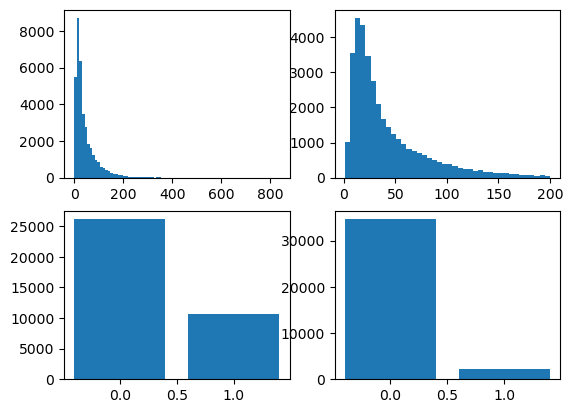

In [45]:
plt.subplot(221)
plt.hist(x=list(df1['wordcount']), bins=80)
plt.subplot(222)
plt.hist(x=list(df1[df1['wordcount'] <= 200]['wordcount']), bins=40)
plt.subplot(223)
plt.bar(x=[0, 1], height=[len(df1[df1['wordcount'] <= 50]), len(df1[df1['wordcount'] > 50])])
plt.subplot(224)
plt.bar(x=[0, 1], height=[len(df1[df1['wordcount'] <= 128]), len(df1[df1['wordcount'] > 128])])
plt.show()

#考虑到这是论述文，所以开头结尾比较重要，数据处理时需要考虑到

In [65]:
df1[df1['wordcount'] == 1].head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,wordcount
11,cc921c5cfda4,00944C693682,stress.,Claim,Adequate,1
452,1ab1030c639a,0A5B8761B187,Disagree,Position,Ineffective,1
1397,210f8f088aa4,1B4E66B0BE0A,pollution.,Claim,Adequate,1
1571,e18b753a740a,1DC6485ABFF6,"interest,",Claim,Ineffective,1
1572,91b5849cdbed,1DC6485ABFF6,funds/workers.,Claim,Ineffective,1
2907,6826ef3d5b63,34C979F3ABAA,promoting,Claim,Ineffective,1
2908,461645ee618c,34C979F3ABAA,protection,Claim,Adequate,1
2909,439210ca27fb,34C979F3ABAA,bills,Claim,Adequate,1
3456,aa83e041a0aa,3E866ECC376A,"enthusiastic,",Claim,Effective,1
4539,8ced2bb31129,50F1D8786126,emotions,Claim,Adequate,1


# RNN

## 数据基本处理

1. 一般语言处理中对全部数据只会取常用的n个词，在此之外的词是不认识的，即先有一本字典

2. 用one-hot编码时，每个词都表示为长n的向量，其中只有一个值是1，其余全是0。
   比如字典的第i（0开始）个单词其one-hot编码中1值的下标是i

## embedding

1. one_hot编码稀疏，所以考虑用稠密向量表示词，比如只用长为m（m<n）的向量表示n个单词，其中单词间关系可以体现在向量间关系中，比如$\vec{男}+\vec{国王}=\vec{皇帝}$

2. 可由embedding层实现这个，embedding记录了一个(n,m)的矩阵，每行都是一个单词的稠密向量，作用是one-hot编码的向量按照其1值的下标i访问这个矩阵第i行，取出这行向量作为新输入
   
3. 具体使用看下面代码说明
   
4. embedding可自行训练出，也可预加载预训练参数。使用预训练参数时，冻结此层

## 初步结果

将batch_size\*len_sentences\*n变为batch_size\*len_sentences\*m

## rnn具体流程

1. 首先初始化hadden_input为全0
   
2. 对每个词，其经过线性层后都会和当前的hadden_input结合(cat或add)并进行一步激活（tanh）运算，所得的输出作为新的hadden_input作为下一个词的初始hadden_input
   
3. cat（最后一维）的话，需要截断，或者另外卷积一次获得新hadden_input
   
4. pytorch的rnn为x[i]通过一liner，hidden通过一liner，两个结果相加经Tanh激活，结果作为新hidden，具体见下面代码

In [28]:
# rnn内部细节
batch_size = 4
sentence_len = 20  #一句话20个词
words_num = 100  #字典记录了100个词
vector_len = 8  #字典的每个词向量长8
X = torch.randint(0, words_num, [batch_size, sentence_len])  #注意输入不为one-hot，只是每个词的字典序号，比如[3,2,10]表示一句话。int
y = torch.as_tensor([[0., 1], [0, 1], [1, 0], [1, 0]])
#print(X)

hidden_layer_num = 1  #多少个hidden用于循环，即多少个循环部分


class MyRNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 128
        self.embedding_layer = nn.Embedding(words_num, vector_len, padding_idx=0)  #100*8,padding_idx为输入长度不够时填充的字典词序号

        #一个循环节
        self.hidden_layer_x = nn.Linear(vector_len, self.hidden_size)  #rnn关键部分
        self.hidden_layer_h = nn.Linear(self.hidden_size, self.hidden_size)  #给h用

        #分类器
        self.out_layer = nn.Linear(self.hidden_size, 2)
        self.activation_layer = nn.Softmax(dim=-1)  #dim=0表示a[i][j][k]按i方向的几个数一起算

    def __init_hidden(self):
        return torch.zeros([hidden_layer_num, batch_size, self.hidden_size])

    def forward(self, x):
        self.hidden = self.__init_hidden()

        print(f"before embedding:{x.shape}")  #[4, 20]
        x = self.embedding_layer(x)
        print(f"after embedding:{x.shape}")  #[4, 20, 8]
        print("-------------")

        out = torch.zeros([sentence_len, batch_size, self.hidden_size])

        #rnn部分
        # 为了更好计算，将数据x变形为为len_sencentces*batch_size*words_num
        # 即x[0]为各句子首单词
        x = x.transpose(0, 1)
        print(f"rnn input:{x.shape}")  #[20, 4, 128]
        for i in range(x.shape[0]):
            a1 = self.hidden_layer_x(x[i])
            a2 = self.hidden_layer_h(self.hidden[0])

            out[i] = self.hidden[0] = nn.Tanh()(a1 + a2)
        print(f"rnn out:{out.shape}")
        print(f"rnn outh:{self.hidden[0].shape}")
        print("-----------")

        #分类器
        o = self.hidden[0]  #即out[x.shape[0]-1]
        o = self.out_layer(o)
        o = self.activation_layer(o)
        print(f"finally shape:{o.shape}")  #[4, 2]
        print(o)

        return o


rnn = MyRNN()
out = rnn(X)

before embedding:torch.Size([4, 20])
after embedding:torch.Size([4, 20, 8])
-------------
rnn input:torch.Size([20, 4, 8])
rnn out:torch.Size([20, 4, 128])
rnn outh:torch.Size([4, 128])
-----------
finally shape:torch.Size([4, 2])
tensor([[0.5867, 0.4133],
        [0.3925, 0.6075],
        [0.4375, 0.5625],
        [0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)


## pytorch的rnn

- 首先就是输入是batch_size\*len_sencentces\*words_num
  
    所以Embedding算是预处理部分，如果需要训练则？？？？？？？？
    
- 主要公式

    $$h_t = \tanh(x_t W_{ih} + b_{ih} + h_{t-1}W_{hh} + b_{hh})$$

    - t

      t为时刻，实质是到第t个字

    - i

      词向量的初始长度

    - h

      隐藏层大小

In [29]:
batch_size = 2
sentence_len = 5
words_num = 10
words_len = 8

X = torch.randint(0, words_num, [batch_size, sentence_len])

X = nn.Embedding(words_num, words_len)(X)
#X = X.transpose(0,1) #batch_size放在第二维，则batch_first设置为False
print(X.shape)

hidden_size = 32
num_layers = 1
H = torch.zeros([num_layers, batch_size, hidden_size])  #可以不设置，则默认为0，这是单向rnn
#HH = torch.zeros([num_layers*2,batch_size,hidden_size]) #双向rnn，需要RNN中设置bidirectional=True

rnn = nn.RNN(
    input_size=words_len,

    #hidden_size，num_layers 都是对网络的设置，与输入数据无关，设置相对自由
    hidden_size=hidden_size,  # hidden层大小
    num_layers=num_layers,  # n个rnn层

    batch_first=True,  #True则输入输出的batch在第一维，否则在第二维（参照上面MyRNN在hidden前的变形）

    bidirectional=False,  #是否双向rnn
)

out, outh = rnn(X, H)  #out为h的集合
print(out.shape, outh.shape)

torch.Size([2, 5, 8])
torch.Size([2, 5, 32]) torch.Size([1, 2, 32])


In [30]:
for i in rnn.named_parameters():
    print(i[0], i[1].shape, type(i[1]))

weight_ih_l0 torch.Size([32, 8]) <class 'torch.nn.parameter.Parameter'>
weight_hh_l0 torch.Size([32, 32]) <class 'torch.nn.parameter.Parameter'>
bias_ih_l0 torch.Size([32]) <class 'torch.nn.parameter.Parameter'>
bias_hh_l0 torch.Size([32]) <class 'torch.nn.parameter.Parameter'>


## 验证

In [31]:
torch.manual_seed(1024)

batch_size = 2
sentence_len = 5
words_num = 10
vector_len = 4

hidden_size = 8
num_layers = 1

X = torch.randint(0, words_num, (batch_size, sentence_len))
em = nn.Embedding(words_num, vector_len)
X = em(X)
print(X.shape)

print('pytorch部分')
rnn = nn.RNN(
    input_size=vector_len,

    hidden_size=hidden_size,
    num_layers=num_layers,

    batch_first=True,
)
out, outh = rnn(X)
print(out.shape, outh.shape)
print(outh[0, 0, :], '\n', out[0, 0, :])
print('-------------------')

print('MyCNN部分')


class MyRNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_layer_x = nn.Linear(vector_len, hidden_size)  #rnn关键部分
        self.hidden_layer_h = nn.Linear(hidden_size, hidden_size)  #h用

        #注意这里无条件复制w、b，所以最好先判断两者形状相等再赋值
        params = list(rnn.parameters())
        # assert self.hidden_layer_x.weight.shape == params[0].shape and
        #        self.hidden_layer_h.weight.shape == params[1].shape and
        #        self.hidden_layer_x.bias.shape == params[2].shape and
        #        self.hidden_layer_h.bias.shape == params[3].shape,
        #     print("shape error")

        self.hidden_layer_x.weight = params[0]
        self.hidden_layer_h.weight = params[1]
        self.hidden_layer_x.bias = params[2]
        self.hidden_layer_h.bias = params[3]

    def __init_hidden(self):
        return torch.zeros([num_layers, batch_size, hidden_size])

    def forward(self, x):
        self.hidden = self.__init_hidden()

        out = torch.zeros([sentence_len, batch_size, hidden_size])

        x = x.transpose(0, 1)
        for i in range(x.shape[0]):
            a1 = self.hidden_layer_x(x[i])
            a2 = self.hidden_layer_h(self.hidden[0])
            self.hidden[0] = nn.Tanh()(a1 + a2)

            out[i] = self.hidden[0]

        return out.transpose(0, 1)


myrnn = MyRNN()
out = myrnn(X)
print(out.shape, myrnn.hidden.shape)
print(myrnn.hidden[0, 0, :], '\n', out[0, 0, :])

torch.Size([2, 5, 4])
pytorch部分
torch.Size([2, 5, 8]) torch.Size([1, 2, 8])
tensor([-0.7137,  0.5926, -0.6244,  0.6198, -0.1706, -0.5207, -0.0612,  0.4735],
       grad_fn=<SliceBackward>) 
 tensor([-0.8456,  0.2111,  0.1764,  0.7712, -0.0146, -0.7987, -0.6467,  0.7652],
       grad_fn=<SliceBackward>)
-------------------
MyCNN部分
torch.Size([2, 5, 8]) torch.Size([1, 2, 8])
tensor([-0.7137,  0.5926, -0.6244,  0.6198, -0.1706, -0.5207, -0.0612,  0.4735],
       grad_fn=<SliceBackward>) 
 tensor([-0.8456,  0.2111,  0.1764,  0.7712, -0.0146, -0.7987, -0.6467,  0.7652],
       grad_fn=<SliceBackward>)


# LSTM
## 基本理解
- rnn因为激活层是Tanh，显然，当前信息几乎不会对很远的计算产生影响，即只能短期记忆
- lstm中引入可以选择“记忆”和“当前”的信息在当前输出的占比 
## 具体介绍 
- 输入是H（类似于rnn的hidden作用），C（当前记忆）
- 一个单元分为记忆门，遗忘门，rnn门，输出门，其相当于四次rnn变换，只不过功能和激活函数不同
   - 记忆门i，Sigmoid激活，即当前rnn输出需要记哪些信息到记忆C中
   - 遗忘门f，Sigmoid激活，即原先记忆需要遗忘哪些信息
   - rnn门g，Tanh激活，就是rnn
   - 输出门o，Sigmoid激活，控制新记忆哪些作为新H
- 公式如下
$$
    \begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$
## pytorch内部细节
- 将四个变换按维度一放在一起，同时计算四个门激活前的输出，输出顺序如上顺序，见如下代码

In [32]:
torch.manual_seed(1024)

batch_size = 2
sentence_len = 5
words_num = 10
words_len = 4

hidden_size = 16
num_layers = 1

X = torch.randint(0, words_num, (batch_size, sentence_len))
em = nn.Embedding(words_num, words_len)
X = em(X)
print(X.shape)

print('pytorch部分')
lstm = nn.LSTM(
    input_size=words_len,

    hidden_size=hidden_size,
    num_layers=num_layers,

    batch_first=True,
)
H = torch.zeros([num_layers, batch_size, hidden_size])
C = torch.zeros([num_layers, batch_size, hidden_size])
out, (outh, outc) = lstm(X, (H, C))  #H、C默认为0
print(out.shape, outh.shape, outc.shape)
print(out[0, 0, :])
print('-------------------')

print('MyLSTM部分')


class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_layer_x = nn.Linear(words_len, hidden_size * 4)  #4*32，即同时输出4组
        self.hidden_layer_h = nn.Linear(hidden_size, hidden_size * 4)  #8*32

        params = list(lstm.parameters())
        # assert self.hidden_layer_x.weight.shape == params[0].shape and
        #        self.hidden_layer_h.weight.shape == params[1].shape and
        #        self.hidden_layer_x.bias.shape == params[2].shape and
        #        self.hidden_layer_h.bias.shape == params[3].shape,
        #     print("shape error")

        self.hidden_layer_x.weight = params[0]
        self.hidden_layer_h.weight = params[1]
        self.hidden_layer_x.bias = params[2]
        self.hidden_layer_h.bias = params[3]

    def __init_H_C(self):
        return torch.zeros([num_layers, batch_size, hidden_size]),
               torch.zeros([num_layers, batch_size, hidden_size])

    def forward(self, x):
        self.H, self.C = self.__init_H_C()
        #H是输出
        #C是记忆

        out = torch.zeros([sentence_len, batch_size, hidden_size])

        x = x.transpose(0, 1)
        for i in torch.arange(x.shape[0]):
            a1 = self.hidden_layer_x(x[i])
            a2 = self.hidden_layer_h(self.H[0])
            a = a1 + a2

            remember_gate = nn.Sigmoid()(a[:, :hidden_size * 1])  #记住下面op什么信息
            forget_gate = nn.Sigmoid()(a[:, hidden_size * 1:hidden_size * 2])  #C遗忘什么信息
            op = nn.Tanh()(a[:, hidden_size * 2:hidden_size * 3])
            output_gate = nn.Sigmoid()(a[:, hidden_size * 3:])  #最终输出

            self.C[0] = self.C[0] * forget_gate + remember_gate * op  #新的记忆
            self.H[0] = nn.Tanh()(self.C) * output_gate  #生成新的输出

            out[i] = self.H[0]

        return out.transpose(0, 1)


mylstm = MyLSTM()
out = mylstm(X)
print(out.shape, mylstm.C.shape, mylstm.H.shape)
print(out[0, 0, :])

torch.Size([2, 5, 4])
pytorch部分
torch.Size([2, 5, 16]) torch.Size([1, 2, 16]) torch.Size([1, 2, 16])
tensor([ 0.0842,  0.0372, -0.1389,  0.0300, -0.1425,  0.0223,  0.0017,  0.3239,
        -0.0413, -0.0924, -0.1835,  0.0621,  0.0484, -0.0894,  0.2133,  0.0063],
       grad_fn=<SliceBackward>)
-------------------
MyLSTM部分
torch.Size([2, 5, 16]) torch.Size([1, 2, 16]) torch.Size([1, 2, 16])
tensor([ 0.0842,  0.0372, -0.1389,  0.0300, -0.1425,  0.0223,  0.0017,  0.3239,
        -0.0413, -0.0924, -0.1835,  0.0621,  0.0484, -0.0894,  0.2133,  0.0063],
       grad_fn=<SliceBackward>)


## 优化
- 遗忘门=1-记忆门，减少运算次数
- 。。。

# attention

语句在文章内，所以以文章为一个数据，可在每段上放上一个特殊标记分隔段落

用attention机制学习

# 文本预处理

In [39]:
import torch
import torch.nn as nn

# 定义模型超参数
batch_size = 64
encoder_seq_length = 10
decoder_seq_length = 10
embedding_dim = 32
hidden_units = 128

# 构建编码器
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, bidirectional=False)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, (hidden, cell)

# 构建注意力机制
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size, _, _ = encoder_outputs.shape
        hidden = hidden.repeat(batch_size, 1, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

# 构建解码器
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.attention = attention

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

# 定义Seq2Seq模型
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            teacher_force = 0.1 < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

# 创建模型实例
INPUT_DIM = 10000  # 假设输入词汇表大小为10000
OUTPUT_DIM = 10000  # 假设输出词汇表大小为10000

enc = Encoder(INPUT_DIM, embedding_dim, hidden_units)
attn = Attention(hidden_units, hidden_units)
dec = Decoder(OUTPUT_DIM, embedding_dim, hidden_units, attn)

model = Seq2Seq(enc, dec)

@torch.no_grad()
def a():
    x = torch.randint(0, 10000, (64, 10))
    y = torch.randint(0, 10000, (64, 10))
    enc_out, (enc_h, enc_c) = enc(x)
    #print(enc_out.shape, enc_h.shape, enc_c.shape) # torch.Size([64, 10, 128]) torch.Size([1, 10, 128]) torch.Size([1, 10, 128])

    model(x,y)



a()

ERROR! Session/line number was not unique in database. History logging moved to new session 676


KeyboardInterrupt: 

## df处理

In [ ]:
#阅览数据
data_dir = "E:/DATA/feedback-prize-effectiveness/"
for root, dirs, files in os.walk(data_dir):
    print(dirs, files)
    break

['test', 'train'] ['sample_submission.csv', 'test.csv', 'train.csv', '来源.txt']


In [ ]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [ ]:
train_df[['discourse_type', 'discourse_effectiveness']].apply(pd.unique)

discourse_type             [Lead, Position, Claim, Evidence, Counterclaim...
discourse_effectiveness                   [Adequate, Ineffective, Effective]
dtype: object

In [ ]:
print(len(pd.unique(train_df['essay_id'])))
for _, _, files in os.walk(os.path.join(data_dir, "train")):
    print(len(files))
    break

4191
4191


In [ ]:
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
test_df.head()

#可知文本类型已知，所以考虑如何将文本类型作为输入

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [ ]:
test_df['discourse_type'].apply(pd.unique)

0                    [Lead]
1                [Position]
2                   [Claim]
3                   [Claim]
4                   [Claim]
5                [Evidence]
6                [Evidence]
7                   [Claim]
8                [Evidence]
9    [Concluding Statement]
Name: discourse_type, dtype: object

In [ ]:
print(len(pd.unique(test_df['essay_id'])))
for _, _, files in os.walk(os.path.join(data_dir, "test")):
    print(len(files))
    break

1
1


In [ ]:
#列的处理
data_dir = "E:/DATA/feedback-prize-effectiveness/"
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

needed_col = ['essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
train_df = train_df[needed_col]
train_df.columns = ['id', 'text', 'type', 'ef']

#typ = {'Lead':1,'Position':2, 'Claim':3, 'Evidence':4, 'Counterclaim':5, 'Rebuttal':6, 'Concluding Statement':7}
#eff = {'Adequate':1, 'Ineffective':2, 'Effective':3}
#train_df['type'] = train_df['type'].apply(lambda x:typ[x])
#train_df['ef'] = train_df['ef'].apply(lambda x:eff[x])

train_df.head()

train_df.to_csv(os.path.join(data_dir, "proc_train.csv"))

,id,text,type,ef
0,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",1,1
1,007ACE74B050,"On my perspective, I think that the face is a ...",2,1
2,007ACE74B050,I think that the face is a natural landform be...,3,1
3,007ACE74B050,"If life was on Mars, we would know by now. The...",4,1
4,007ACE74B050,People thought that the face was formed by ali...,5,1


In [ ]:
train_df = pd.read_csv(os.path.join(data_dir, "proc_train.csv"))

In [ ]:
#词处理
text_field = torchtext.data.Field(sequential=True, tokenize='spacy', lower=True, batch_first=True)  #会自行处理停用词和符号
label_field = torchtext.data.Field(sequential=False, use_vocab=False)  #是单独的类别，而不是文本，原数据可以是数字

fields = [('id', None), ('text', text_field), ('type', label_field), ('ef', label_field)]
train_dataset = torchtext.data.TabularDataset(os.path.join(data_dir, "proc_train.csv"), 'csv', fields)

text_field.build_vocab(train_dataset, vector='glove.6B.100d')
label_field.build_vocab(train_dataset)

AttributeError: module 'torchtext' has no attribute 'legacy'

# 开始

## 基本参数

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

data_dir = "E:/DATA/feedback-prize-effectiveness/"

assist_dir = "./assist/"
if (not os.path.exists(assist_dir)):
    os.mkdir(assist_dir)
models_dir = "./models_dir/"
if (not os.path.exists(models_dir)):
    os.mkdir(models_dir)
exp_name = "exp1"
exp_dir = os.path.join(models_dir, exp_name)
if (not os.path.exists(exp_dir)):
    os.mkdir(exp_dir)

word_count = 60  #不能让大部分数据空值太多
max_word_count = 100  #超过这个值考虑取首尾
word_vector_dir = "E:/DATA/glove.6B/"

stop_words_file = "E:/DATA/english_stop_words.txt"

train_batch_size = 64
valid_batch_size = 128
test_batch_size = 128
epochs = 15

seed = 101


def set_seed():
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed()

exp_name = "exp1"

cpu


## df预处理

### 未优化版

In [3]:
#只运行一次，产生处理过的csv

#列重命名
train_df1 = pd.read_csv(os.path.join(data_dir, "train.csv"))
needed_col = ['essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
train_df1 = train_df1[needed_col]
train_df1.columns = ['id', 'text', 'type', 'ef']

#type加到text首
train_df1['text'] = train_df1[['text', 'type']].apply(
    lambda x: x[1] + "." + x[0] if x[1] == "Concluding Statement" else "Conclusion." + x[0], axis=1)

#type数字化
typ = {'Claim': 0, "Concluding Statement": 1, "Counterclaim": 2, "Evidence": 3, "Lead": 4, "Position": 5, "Rebuttal": 6}
train_df1['type'] = train_df1['type'].apply(lambda x: typ[x])
#ef数字化
eff = {'Adequate': 0, 'Ineffective': 1, 'Effective': 2}
train_df1['ef'] = train_df1['ef'].apply(lambda x: eff[x])

#统计单词个数供划分用
train_df1['word_count'] = train_df1['text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)

#分训练集验证集
train_df1['fold'] = [-1] * len(train_df1)
skf = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_i, valid_i) in enumerate(skf.split(train_df1, train_df1['type'])):
    train_df1.loc[valid_i, 'fold'] = i + 1
train_df = train_df1[train_df1['fold'] != 1]
train_df = train_df.drop(labels=['fold'], axis=1)
valid_df = train_df1[train_df1['fold'] == 1]
valid_df = valid_df.drop(labels=['fold'], axis=1)

#保存
train_df.to_csv(os.path.join(assist_dir, "train.csv"), index=None)
valid_df.to_csv(os.path.join(assist_dir, "valid.csv"), index=None)

#测试集，也需要对text进行处理，同时获取word_count
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
needed_col = ['essay_id', 'discourse_text', 'discourse_type']
test_df = test_df[needed_col]
test_df.columns = ['id', 'text', 'type']

test_df['text'] = test_df[['text', 'type']].apply(
    lambda x: x[1] + "." + x[0] if x[1] == "Concluding Statement" else "Conclusion." + x[0], axis=1)
#type数字化
typ = {'Claim': 0, "Concluding Statement": 1, "Counterclaim": 2, "Evidence": 3, "Lead": 4, "Position": 5, "Rebuttal": 6}
test_df['type'] = test_df['type'].apply(lambda x: typ[x])

#为了下面生成train、valid、test的代码可以写到一起，对test也设计ef列
test_df['ef'] = [0] * len(test_df)

test_df['word_count'] = test_df['text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)

test_df.to_csv(os.path.join(assist_dir, "test.csv"), index=None)


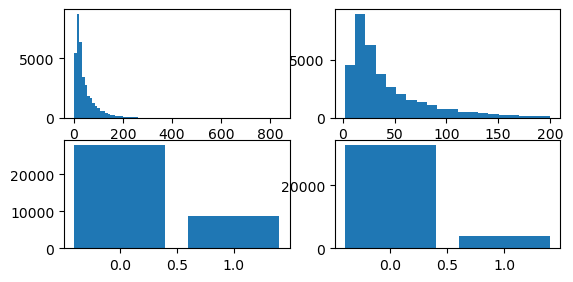

In [4]:
plt.subplot(321)
plt.hist(x=list(train_df1['word_count']), bins=80)

plt.subplot(322)
plt.hist(x=list(train_df1[train_df1['word_count'] <= 200]['word_count']), bins=20)

plt.subplot(323)
plt.bar(x=[0, 1], height=[len(train_df1[train_df1['word_count'] <= word_count]),
                          len(train_df1[train_df1['word_count'] > word_count])])

plt.subplot(324)
plt.bar(x=[0, 1], height=[len(train_df1[train_df1['word_count'] <= max_word_count]),
                          len(train_df1[train_df1['word_count'] > max_word_count])])

plt.show()

In [5]:
train_df1[['word_count']].describe()

,word_count
count,36765.000000
mean,45.841480
std,46.842673
min,2.000000
25%,17.000000
50%,29.000000
75%,58.000000
max,837.000000


### 优化版

数据好像没什么变化？

In [6]:
#只有训练集进行太长截断取首尾

#列重命名
train_df1 = pd.read_csv(os.path.join(data_dir, "train.csv"))
needed_col = ['essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
train_df1 = train_df1[needed_col]
train_df1.columns = ['id', 'text', 'type', 'ef']

#type加到text首
train_df1['text'] = train_df1[['text', 'type']].apply(
    lambda x: x[1] + "." + x[0] if x[1] == "Concluding Statement" else "Conclusion." + x[0], axis=1)

#type数字化
typ = {'Claim': 0, "Concluding Statement": 1, "Counterclaim": 2, "Evidence": 3, "Lead": 4, "Position": 5, "Rebuttal": 6}
train_df1['type'] = train_df1['type'].apply(lambda x: typ[x])
#ef数字化
eff = {'Adequate': 0, 'Ineffective': 1, 'Effective': 2}
train_df1['ef'] = train_df1['ef'].apply(lambda x: eff[x])

#验证集的text保存原样
train_df1['word_count'] = train_df1['text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)

#划分
train_df1['fold'] = [-1] * len(train_df1)
skf = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_i, valid_i) in enumerate(skf.split(train_df1, train_df1['type'])):
    train_df1.loc[valid_i, 'fold'] = i + 1
train_df = train_df1[train_df1['fold'] != 1]
train_df = train_df.drop(labels=['fold'], axis=1)
valid_df = train_df1[train_df1['fold'] == 1]
valid_df = valid_df.drop(labels=['fold'], axis=1)

valid_df.to_csv(os.path.join(assist_dir, "valid1.csv"), index=None)


#对训练集再单独处理
def f(x):
    #句子太长优先取首尾
    text = x['text']
    sp_word = r"[\n|\s|,|?|!|.]"
    sp_sentence = r"[\n|?|!|.]"  #不以,划分

    L = len(list(filter(None, re.split(sp_word, text))))
    if L > max_word_count:
        sentences = list(filter(None, re.split(sp_sentence, text)))

        if len(sentences) == 1:
            return text

        res = sentences[0] + "." + sentences[1] + "." + sentences[-1] + "."

        i = 2
        while len(list(filter(None, re.split(sp_word, res)))) < word_count:
            if i == len(sentences) - 1:
                break
            res += sentences[i] + "."

            i += 1
        return res

    else:
        return text


train_df['text'] = train_df[['text']].apply(f, axis=1)
train_df['word_count'] = train_df['text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)
train_df.to_csv(os.path.join(assist_dir, "train1.csv"), index=None)

#测试集也不用截断
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
needed_col = ['essay_id', 'discourse_text', 'discourse_type']
test_df = test_df[needed_col]
test_df.columns = ['id', 'text', 'type']

test_df['text'] = test_df[['text', 'type']].apply(
    lambda x: x[1] + "." + x[0] if x[1] == "Concluding Statement" else "Conclusion." + x[0], axis=1)

#type数字化
typ = {'Claim': 0, "Concluding Statement": 1, "Counterclaim": 2, "Evidence": 3, "Lead": 4, "Position": 5, "Rebuttal": 6}
test_df['type'] = test_df['type'].apply(lambda x: typ[x])

#为了下面生成train、valid、test的代码可以写到一起，对test也设计ef列
test_df['ef'] = [0] * len(test_df)

test_df['word_count'] = test_df['text'].apply(
    lambda x: len(list(filter(None, re.split(r"[\n|\s|,|!|.|?]", x))))
)

test_df.to_csv(os.path.join(assist_dir, "test1.csv"), index=None)

In [7]:
train_df1[['word_count']].describe()

,word_count
count,36765.000000
mean,45.841480
std,46.842673
min,2.000000
25%,17.000000
50%,29.000000
75%,58.000000
max,837.000000


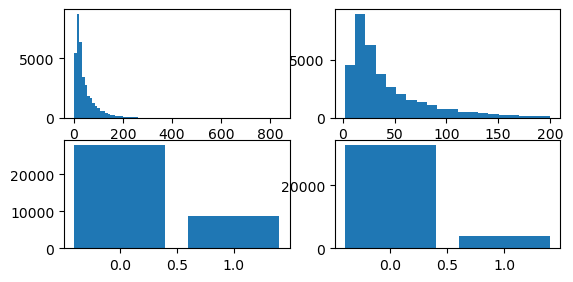

In [8]:
plt.subplot(321)
plt.hist(x=list(train_df1['word_count']), bins=80)

plt.subplot(322)
plt.hist(x=list(train_df1[train_df1['word_count'] <= 200]['word_count']), bins=20)

plt.subplot(323)
plt.bar(x=[0, 1], height=[len(train_df1[train_df1['word_count'] <= word_count]),
                          len(train_df1[train_df1['word_count'] > word_count])])

plt.subplot(324)
plt.bar(x=[0, 1], height=[len(train_df1[train_df1['word_count'] <= max_word_count]),
                          len(train_df1[train_df1['word_count'] > max_word_count])])

plt.show()

## iter

In [9]:
train_df = pd.read_csv(os.path.join(assist_dir, "train.csv"))
valid_df = pd.read_csv(os.path.join(assist_dir, "valid.csv"))
test_df = pd.read_csv(os.path.join(assist_dir, "test.csv"))

# 词处理
with open(stop_words_file, 'r') as f:
    stop_words = [i.split("\n")[0] for i in f.readlines()]
text_field = data.Field(
    sequential=True,
    tokenize='spacy',
    tokenizer_language="en_core_web_sm",
    lower=True,
    batch_first=True,
    fix_length=word_count,
    stop_words=stop_words
)
label_field = data.Field(sequential=False, use_vocab=False)  #已经是数字，所以use_vocab=False

#就是这里，需要它们的fields都为这个
fields = [('id', None), ('text', text_field), ('type', label_field), ('ef', label_field), ('wordcount', label_field)]

train_ds, valid_ds, test_ds = data.TabularDataset.splits(
    path=assist_dir, format='csv',
    train='train.csv', validation='valid.csv', test='test.csv',
    fields=fields,
    skip_header=True
)

text_field.build_vocab(
    train_ds, valid_ds, test_ds,
    vectors='glove.6B.50d',
    vectors_cache=word_vector_dir
)
label_field.build_vocab(train_ds, valid_ds, test_ds)

'''
for w,i in text_field.vocab.stoi.items():#词和相应index
    print(w,i)
print(text_field.vocab.vectors.shape)#[29278, 100]
'''

train_iter, valid_iter, test_iter = torchtext.legacy.data.BucketIterator.splits(  #长度相似的会放同一批
    (train_ds, valid_ds, test_ds),
    batch_sizes=(train_batch_size, valid_batch_size, test_batch_size),  #一样的话就是batch_size
    sort=True,
    sort_within_batch=True,
    sort_key=lambda x: int(x.wordcount),
    device=device
)

print(len(train_iter), len(valid_iter), len(test_iter))

460 58 1


In [16]:
ii = 0
for w, i in text_field.vocab.stoi.items():  #词和相应index
    if 128 < ii < 140 or 0 < ii < 5:
        print(w, i)
    ii += 1
    if ii == 141:
        break
print(text_field.vocab.vectors.shape)  #[29278, 50],共29278个词，每个词50维

<pad> 1
. 2
, 3
conclusion 4
understand 129
; 130
chance 131
extracurricular 132
country 133
taking 134
big 135
're 136
paragraph 137
wrong 138
classroom 139
torch.Size([29751, 50])


In [18]:
for i in train_iter:
    print(i.input_fields)
    break

['text', 'type', 'ef', 'wordcount']


## model

In [5]:
#model参数

#embedding层
embedding_shape = text_field.vocab.vectors.shape
embedding_weight = text_field.vocab.vectors

#lstm层
hidden_size = 2
num_layers = 1  #不太清楚设置成其他值怎么弄，下面的代码主要针对为1情况
bidirectional = False  #是否双向lstm，双向的forward可能要变，初步考虑如下

In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.embedding = nn.Embedding(*embedding_shape)
        self.embedding.weight.data.copy_(embedding_weight)  #不能直接用=

        self.lstm = nn.LSTM(
            input_size=text_field.vocab.vectors.shape[1],
            batch_first=True,

            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, 3),
            nn.Softmax(dim=-1)
        )

    def __initHC__(self, batch_size):
        self.H = torch.zeros([num_layers, batch_size, hidden_size])
        self.C = torch.zeros([num_layers, batch_size, hidden_size])

    def forward(self, x):
        with torch.no_grad():
            x = self.embedding(x)

        #self.__initHC__(batch_size = x.shape[0])
        #x, (outH,outC) = self.lstm(x,(self.H,self.C))
        x, (outH, outC) = self.lstm(x)

        """
        if bidirectional:#不一定是这样
            out = self.classifier(x[:,[-1],:] + x[:,[0],:])
        else:
            out = self.classifier(x[:,[-1],:])
        """
        if bidirectional:  #不一定是这样
            out = self.classifier(outH[0] + outH[0])
        else:
            out = self.classifier(outH[0])

        return out


model = MyModel()

In [21]:
a = next(model.embedding.parameters()).clone()

In [25]:
print(a)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<CloneBackward>)


In [13]:
model.to(device)

model(list(train_iter)[0].text)

tensor([[0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.3839, 0.3119, 0.3042],
        [0.383

## loss等 

In [10]:
loss_func = nn.CrossEntropyLoss()
#loss_func(pred_y,y)

optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=len(train_iter) * epochs + 10,
    eta_min=1e-6
)  #整个训练过程完成max->min

## run

In [ ]:
class Runner():
    """基本设置"""

    def __init__(self):
        self.__pre_proc()

    def __pre_proc(self):
        model.to(device)

        self.__init_loss()

    def __init_loss(self):
        self.train_loss = []
        self.valid_loss = []

    def get_loss(self, kind):
        if kind == 'train':
            return self.train_loss
        elif kind == 'valid':
            return self.valid_loss
        else:
            raise ValueError("kind值错误")

    def __save_model(self, epoch):
        path = exp_dir + f"/epoch_{epoch}_params.pkl"
        model_params = model.state_dict()
        torch.save(model_params, path)

    def set_model(self, epoch):
        """
        从文件读出参数

        Args:
            epoch: 第几轮的参数
        """
        path = exp_dir + f"/epoch_{epoch}_params.pkl"
        model_params = torch.load(path)
        model.load_state_dict(model_params)

    """训练相关"""

    def train(self):
        self.__init_loss()
        for epoch in range(epochs):
            self.train_one_epoch(epoch)
            self.valid_one_epoch(epoch)

            #self.__smw_proc(epoch)

    def train_one_epoch(self, epoch):
        model.train()

        scaler = amp.GradScaler()

        epoch_loss = 0  #统计本epoch的总loss，最后求平均loss
        data_size = 0
        pbar = tqdm(enumerate(train_iter), total=len(train_iter), desc=f'epoch_{epoch} train')
        for i, batch in pbar:
            x = batch.text
            y = batch.ef

            with amp.autocast():
                predy = model(x)
                batch_loss = loss_func(predy.squeeze(1), y)
            scaler.scale(batch_loss).backward()

            if i % 1 == 0:
                scaler.step(optimizer)  #1个batch更新一次参数
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()  #同时更新lr

            epoch_loss += float(batch_loss) * train_batch_size
            data_size += train_batch_size

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(
                peoch_avg_loss=f'{epoch_loss / data_size:0.4f}',
                lr=f'{current_lr:0.4f}',
                gpu_mem=f'{mem:0.2f} GB'
            )

        torch.cuda.empty_cache()
        gc.collect()

        self.train_loss.append(epoch_loss / data_size)
        self.__save_model(epoch)

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        model.eval()

        scaler = amp.GradScaler()

        epoch_loss = 0  #统计本epoch的总loss，最后求平均loss
        data_size = 0
        pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), desc=f'epoch_{epoch} valid')
        for i, batch in pbar:
            x = batch.text
            y = batch.ef

            with amp.autocast():
                predy = model(x)
                batch_loss = loss_func(predy.squeeze(1), y)

            epoch_loss += float(batch_loss) * valid_batch_size
            data_size += valid_batch_size

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            pbar.set_postfix(
                peoch_avg_loss=f'{epoch_loss / data_size:0.4f}',
                gpu_mem=f'{mem:0.2f} GB'
            )

        torch.cuda.empty_cache()
        gc.collect()

        self.valid_loss.append(epoch_loss / data_size)

    """测试集"""

    def test(self):
        """
        返回预测结果和loss
        """

        temp = []  #存储结果

        model.eval()

        scaler = amp.GradScaler()

        cur_loss = 0
        data_size = 0
        pbar = tqdm(enumerate(test_iter), total=len(test_iter), desc='test')
        for i, batch in pbar:
            x = batch.text
            y = batch.ef

            with amp.autocast():
                predy = model(x)
                temp.append((predy.detach().cpu().numpy(), y.detach().cpu().numpy()))
                batch_loss = loss_func(predy.squeeze(1), y)

            cur_loss += float(batch_loss) * test_batch_size
            data_size += test_batch_size

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            pbar.set_postfix(
                loss=f'{cur_loss / data_size:0.4f}',
                gpu_mem=f'{mem:0.2f} GB'
            )

        torch.cuda.empty_cache()
        gc.collect()

        res = []
        for predy, y in temp:
            for i in range(predy.shape[0]):
                res.append((list(predy[i]), list(y[i])))

        return cur_loss / data_size, res

    """可视化结果"""

    def __smw_proc(self, epoch):

        pass

        with SummaryWriter(exp_name) as smw:
            smw.add_scalars(
                main_tag='datas/loss',
                tag_scalar_dict={
                    "train_loss": self.train_loss[f"epoch_{epoch}"],
                    "valid_loss": self.valid_loss[f"epoch_{epoch}"],
                },
                global_step=epoch
            )
            smw.add_scalar(
                tag='datas/lr',
                scalar_value=optimizer.param_groups[0]['lr'],
                global_step=epoch
            )

            imgs, masks, pred_masks = self.__get_show_result('train', 2)
            for i in range(imgs.shape[0]):
                dis_imgs = np.stack([i for i in imgs[i]] + [i for i in masks[i]] + [i for i in pred_masks[i]], axis=0)
                dis_imgs = dis_imgs[:, np.newaxis]
                self.smw.add_images(
                    tag=f"epoch_{epoch}/train/{i}",
                    img_tensor=dis_imgs
                )
            imgs, masks, pred_masks = self.__get_show_result('valid', 2)
            for i in range(imgs.shape[0]):
                dis_imgs = np.stack([i for i in imgs[i]] + [i for i in masks[i]] + [i for i in pred_masks[i]], axis=0)
                dis_imgs = dis_imgs[:, np.newaxis]
                smw.add_images(
                    tag=f"epoch_{epoch}/valid/{i}",
                    img_tensor=dis_imgs
                )


runner = Runner()

In [ ]:
runner.train()

In [11]:
model.to(device)
model.eval()
for batch in train_iter:
    out = model(batch.text.to(device))
    y = batch.ef
    break
print(out[0], y)

tensor([[0.2034, 0.2028, 0.5938]], grad_fn=<SelectBackward>) tensor([0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 0,
        1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1])
